## Importing the Libraries

In [2]:
import gc
import os
import time
import warnings
from itertools import combinations
from warnings import simplefilter

import joblib
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit


warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

is_offline = False
is_train = True
is_infer = True
max_lookback = np.nan
split_day = 435


## What data we have?

In [3]:
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

df = df.dropna(subset=["target"])

df.reset_index(drop=True, inplace=True)

df_shape = df.shape

In [4]:
df_shape

(5237892, 17)

In [5]:
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [15]:
df.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


### Summary of Data & Interpretation

1. Dataset consists of 5237980 observations of 17 different features

2. Features:
    - stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
    - date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
    - seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
    - imbalance_size - The amount unmatched at the current reference price (in USD).
    - imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
        - buy-side imbalance; 1
        - sell-side imbalance; -1
        - no imbalance; 0
    - reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
    - matched_size - The amount that can be matched at the current reference price (in USD).
    - far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
    - near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
    - [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.
    - [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
    - wap - The weighted average price of the most competitive buy/sell level in the non-auction book.
        - $(𝐵𝑖𝑑𝑃𝑟𝑖𝑐𝑒∗𝐴𝑠𝑘𝑆𝑖𝑧𝑒+𝐴𝑠𝑘𝑃𝑟𝑖𝑐𝑒∗𝐵𝑖𝑑𝑆𝑖𝑧𝑒)/(𝐵𝑖𝑑𝑆𝑖𝑧𝑒+𝐴𝑠𝑘𝑆𝑖𝑧𝑒)$
    - target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
        - The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
        - The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
        - Where t is the time at the current observation, we can define the target
        - $𝑇𝑎𝑟𝑔𝑒𝑡=(𝑆𝑡𝑜𝑐𝑘𝑊𝐴𝑃𝑡+60𝑆𝑡𝑜𝑐𝑘𝑊𝐴𝑃𝑡−𝐼𝑛𝑑𝑒𝑥𝑊𝐴𝑃𝑡+60𝐼𝑛𝑑𝑒𝑥𝑊𝐴𝑃𝑡)∗10000$

In [16]:
# Count of missing values in dataframe
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
row_id                           0
dtype: int64

In [17]:
# Number of days data we have in the dataset
print(df['date_id'].unique())
print(len(df['date_id'].unique()))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

Number of stocks traded on each day:
     date_id  num_stocks_traded
0          0                191
1          1                191
2          2                191
3          3                191
4          4                192
..       ...                ...
476      476                200
477      477                200
478      478                200
479      479                200
480      480                200

[481 rows x 2 columns]



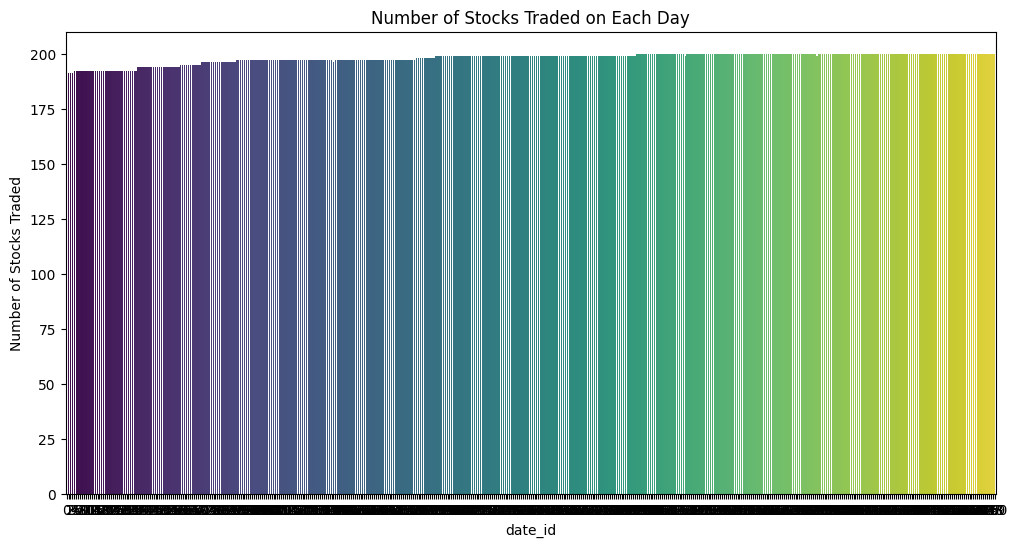

In [18]:
# Number of stocks traded on each day 
stocks_traded_per_day = df.groupby('date_id')['stock_id'].nunique().reset_index()
stocks_traded_per_day.columns = ['date_id', 'num_stocks_traded']

print("Number of stocks traded on each day:")
print(stocks_traded_per_day)
print()

plt.figure(figsize=(12, 6))
plt.tight_layout()
# figure.automft_xdate()
sns.barplot(x='date_id', y='num_stocks_traded', data=stocks_traded_per_day, palette="viridis")
plt.title('Number of Stocks Traded on Each Day')
plt.xlabel('date_id')
plt.ylabel('Number of Stocks Traded')
plt.show()

Number of times each stock traded on each day:
Index(['date_id',         0,         1,         2,         3,         4,
               5,         6,         7,         8,
       ...
             190,       191,       192,       193,       194,       195,
             196,       197,       198,       199],
      dtype='object', name='stock_id', length=201)
stock_id  date_id     0     1     2     3     4     5     6     7     8  ...  \
0               0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  ...   
1               1  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  ...   
2               2  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  ...   
3               3  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  ...   
4               4  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  ...   
..            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
476           476  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  ...   
47

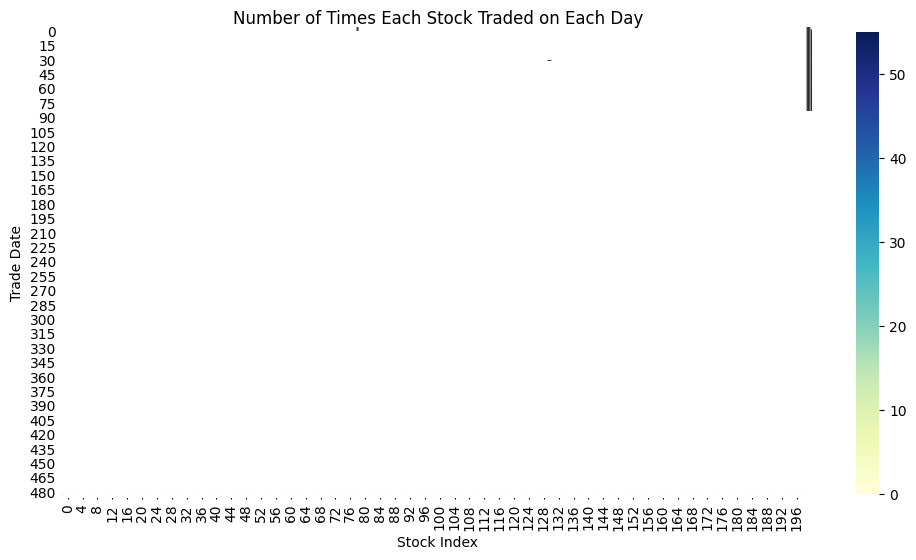

In [19]:
# Number of times each stock traded on each day (Create a separate dataframe for it)
trades_per_stock_per_day = df.groupby(['date_id', 'stock_id']).size().unstack().reset_index()
trades_per_stock_per_day = trades_per_stock_per_day.fillna(0)

print("Number of times each stock traded on each day:")
print(trades_per_stock_per_day.columns)
print(trades_per_stock_per_day)

print()

plt.figure(figsize=(12, 6))
sns.heatmap(trades_per_stock_per_day.set_index('date_id'), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Number of Times Each Stock Traded on Each Day')
plt.xlabel('Stock Index')
plt.ylabel('Trade Date')
plt.show()

### Summary of Data & Interpretation - 2

1. We have stock-exchange data of 481 days
2. We have last 9 minute(540 seconds) data of 191-200 stocks which are traded on each day at nasdaq exchange
3. On each day for each stock we have 55 observations, where two consequent observations are 10 seconds apart. Hence, 55 observations and 10 seconds apart, which make it a final 9 minutes window. 1st observation at 0 seconds, 2nd observation at 10 seconds, 3rd observation at 20 seconds and 55th observation at 540th seconds.
4. Our objective is to ?
5. At the begining we have 191 stocks trading on each day, by the end 200 stocks are trading on each day



## EDA on stocks = [79, 102, 135]

- As part of this intial report, we will be performing EDA on selected stocks. Later, we'll proceed to generalize the findings on rest of the stocks.

- In this EDA I'll be exploring stocks with id  79, 102, 135
- I particularly selected these because, these are the few stocks that didn't exist from the beginning. With these stocks we can find patterns how stock price is behaving at the closing time in it's initial days at the exchange.
- Hence I'm cleasing thye dataset accordingly

In [20]:
# pre-processed dataframe (PDF)
pdf = df[(df['stock_id']==79) | (df['stock_id']==102) | (df['stock_id']==135)]

### EDA on stock_id 79

- Observe the change of wap with bid and ask price
- Notice how change in volume of stocks and imbalance changeing the reference price. 
- Record the fluctuation (change in reference price on each day with repect to it's starting reference price). This is extremely important for the stock which are added , so we can have greater understanding of price movements in the initaial days.

In [21]:
current_stock_id = 79
df_79 = pdf[pdf['stock_id']==79]

print(df_79.shape)
print(df_79.isnull().sum())
print(df_79.describe())

(16500, 17)
stock_id                      0
date_id                       0
seconds_in_bucket             0
imbalance_size                0
imbalance_buy_sell_flag       0
reference_price               0
matched_size                  0
far_price                  9025
near_price                 9000
bid_price                     0
bid_size                      0
ask_price                     0
ask_size                      0
wap                           0
target                        0
time_id                       0
row_id                        0
dtype: int64
       stock_id       date_id  seconds_in_bucket  imbalance_size  \
count   16500.0  16500.000000       16500.000000    1.650000e+04   
mean       79.0    330.500000         270.000000    3.586637e+06   
std         0.0     86.604684         158.749889    8.026413e+06   
min        79.0    181.000000           0.000000    0.000000e+00   
25%        79.0    255.750000         130.000000    3.716453e+05   
50%        79.0    330.

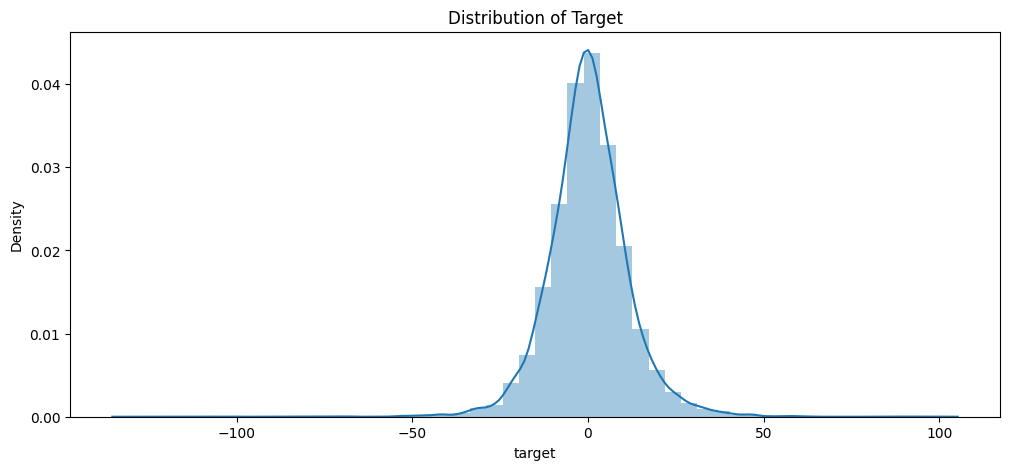

In [22]:
# Target Distribution
plt.figure(figsize=(12,5))
plt.title("Distribution of Target")
ax = sns.distplot(df_79['target'])

In [23]:
# First day in the stock exhange is ?
print(df_79['date_id'].min())
stocks_first_day = df_79['date_id'].min()

# First reference price?
starting_reference_price = df_79[(df_79['date_id']==181) & (df_79['seconds_in_bucket']==0)]['reference_price'].iloc[0]
print(starting_reference_price)

181
0.999901


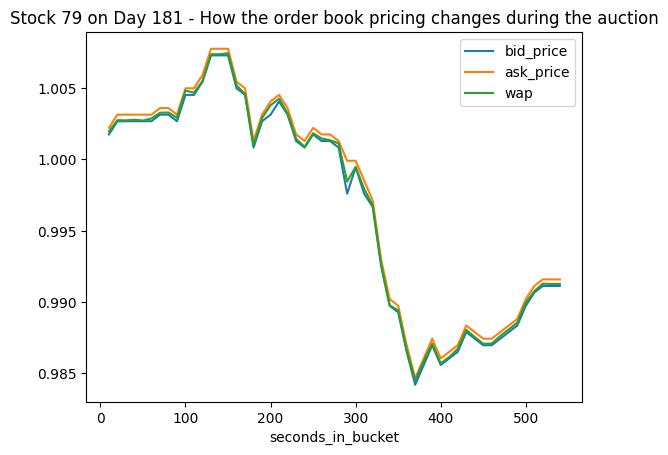

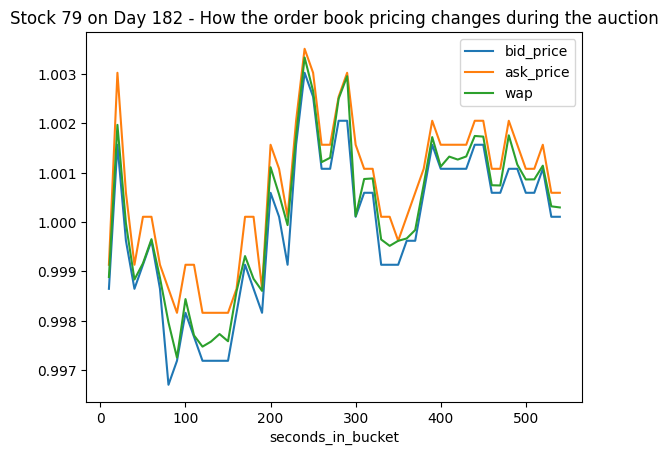

In [24]:
# I siddartha writing the comments for my understanding

# Understand the movement of weighted average price(wap), ask_price, bid_price on day 181

## 1. No null values in wap, ask_price, bid_price (verified)
for i in range(stocks_first_day, stocks_first_day+2):
    (
        df_79
        .query(f'stock_id =={current_stock_id} & date_id =={i}')
        [['seconds_in_bucket','bid_price','ask_price', 'wap']]
        .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f"Stock {current_stock_id} on Day {i} - How the order book pricing changes during the auction")
    )

In [25]:
# Record the fluctuation (The distance from initial_reference_price)

distance = df_79[df_79['seconds_in_bucket'] == 540]['reference_price'].iloc[:] - starting_reference_price
print(distance.iloc[-1])

-0.005199000000000065


<class 'numpy.ndarray'>
(300,)


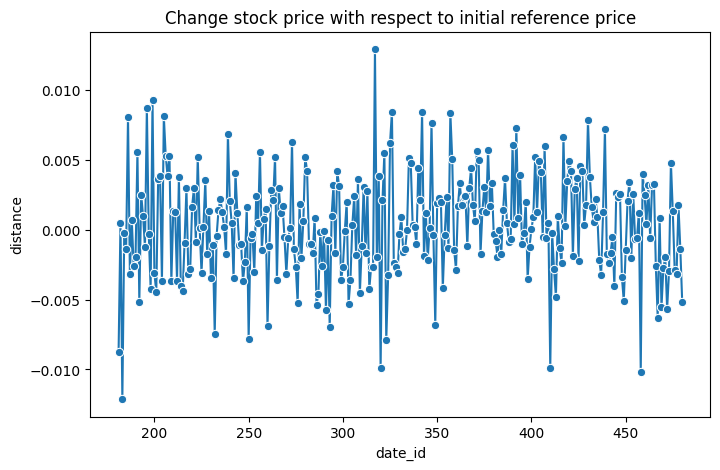

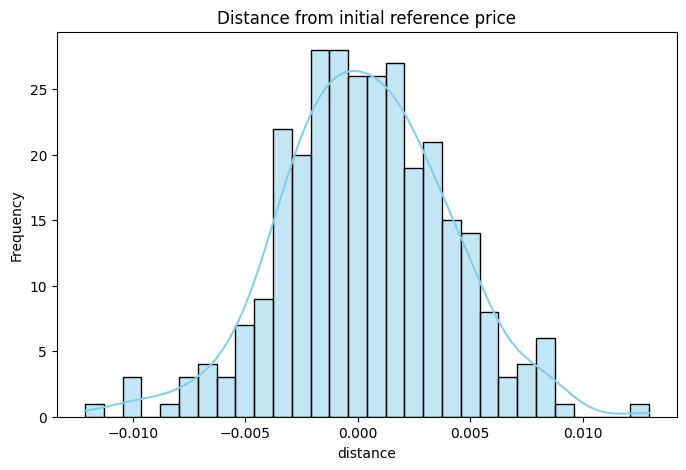

In [26]:
# Create a DataFrame with 'distance' and 'date_id'
unique_dates = df_79['date_id'].unique()
print(type(unique_dates))
print(unique_dates.shape)
temp_df = pd.DataFrame({'distance': distance.values, 'date_id': unique_dates})

plt.figure(figsize=(8, 5))
sns.lineplot(x='date_id', y='distance', data=temp_df, marker='o')
plt.title('Change stock price with respect to initial reference price')
plt.xlabel('date_id')
plt.ylabel('distance')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=temp_df, x='distance', bins=30, kde=True, color='skyblue')
plt.title('Distance from initial reference price')
plt.xlabel('distance')
plt.ylabel('Frequency')
plt.show()

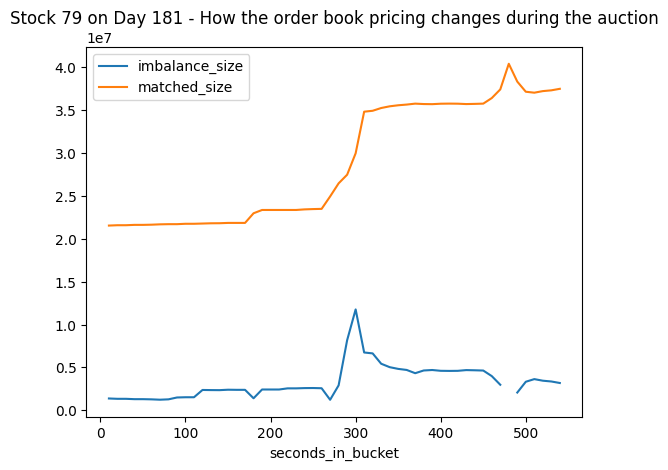

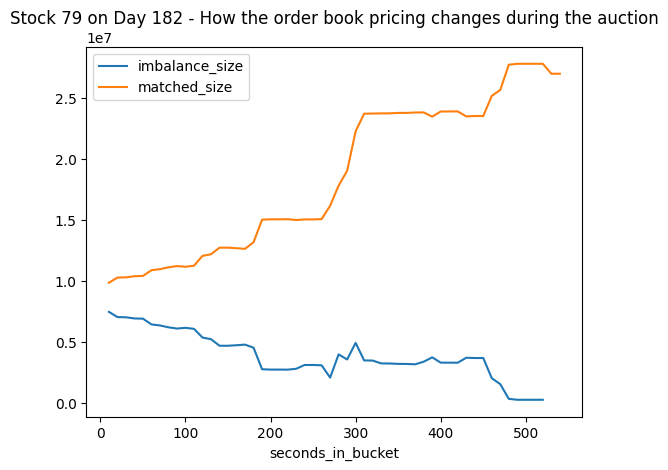

In [27]:
# Observe how the imbalance and matched chnging with each other

for i in range(stocks_first_day, stocks_first_day+2):
    (
        df_79
        .query(f'stock_id =={current_stock_id} & date_id =={i}')
        [['seconds_in_bucket','imbalance_size', 'matched_size']]
        .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f"Stock {current_stock_id} on Day {i} - How the order book pricing changes during the auction")
    )

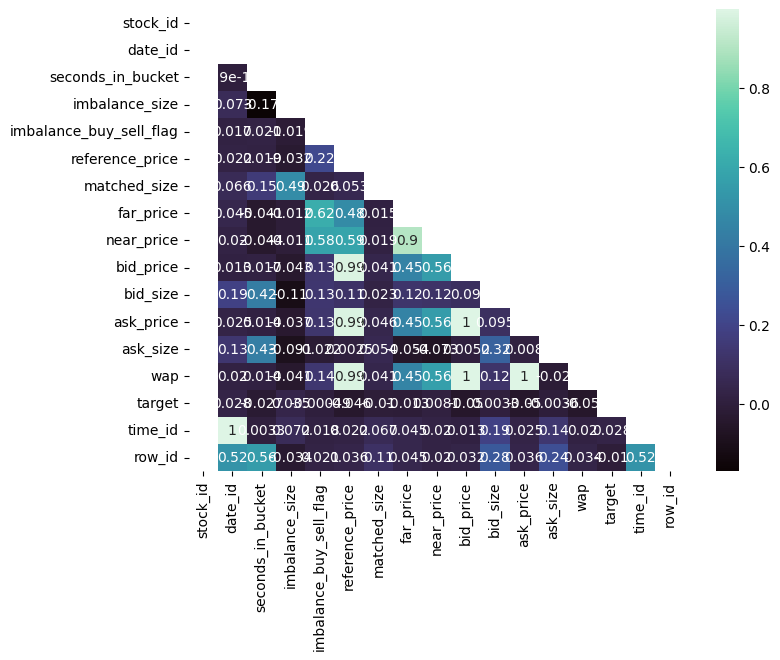

In [28]:
# correlation 
plt.figure(figsize=(8,6))
corr=df_79.corr()
sns.heatmap(corr,annot=True,cmap='mako',mask=np.triu(corr))
plt.show()

1. The first day stock_id 79 traded on is 181st day
2. The first reference price of stock_id 79 is 0.999901
3. Wap is always sitting in-between ask-bid price
4. In the initial days, the stock_id 79 is being stronly balanced. and maintaining very less unbalanced orders.
5. The price difference between initial day price and last day price is -0.005199000000000065. (In almost 300 days the stock price actually decreased below it's initial price)
6. Checked the correlation between target and other variables, the target is seems like have no correlation with the other variables. Need to investigate further.

### EDA on stock_id 102

1.  Check the correlation with the target variable.
2.  Movement of unbalanced and matched orders
3.  Check whether it is buy/sell dominant in intial 10 days.
4.  Check If this stock also getting more balanced in terms of buy/sell orders with time from 0 to 540.


In [29]:
current_stock_id = 102
df_102 = pdf[pdf['stock_id']==current_stock_id]

print(df_102.shape)
print(df_102.isnull().sum())
print(df_102.describe())

(10230, 17)
stock_id                      0
date_id                       0
seconds_in_bucket             0
imbalance_size                0
imbalance_buy_sell_flag       0
reference_price               0
matched_size                  0
far_price                  5631
near_price                 5580
bid_price                     0
bid_size                      0
ask_price                     0
ask_size                      0
wap                           0
target                        0
time_id                       0
row_id                        0
dtype: int64
       stock_id       date_id  seconds_in_bucket  imbalance_size  \
count   10230.0  10230.000000       10230.000000    1.023000e+04   
mean      102.0    387.500000         270.000000    4.816620e+06   
std         0.0     53.695423         158.752838    1.576035e+07   
min       102.0    295.000000           0.000000    0.000000e+00   
25%       102.0    341.000000         130.000000    4.067172e+05   
50%       102.0    387.

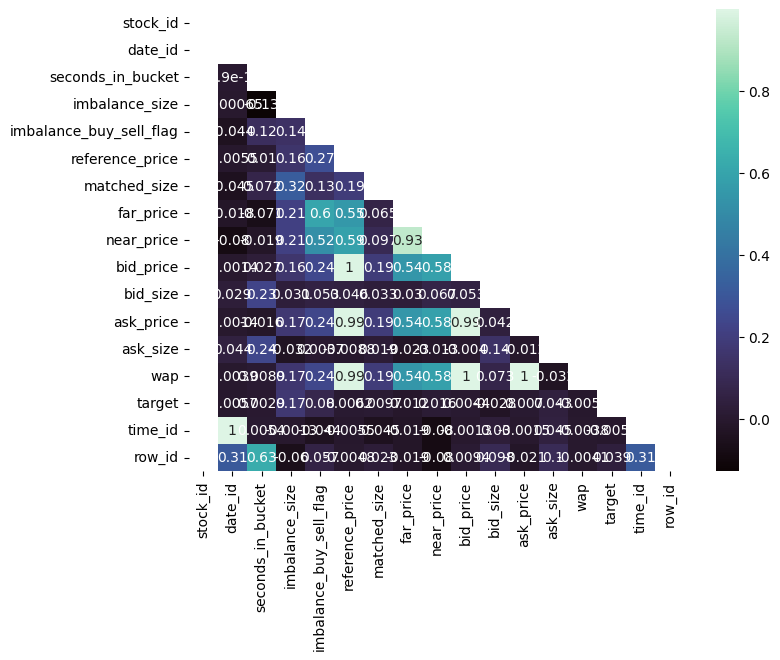

In [30]:
# correlation 
plt.figure(figsize=(8,6))
corr=df_102.corr()
sns.heatmap(corr,annot=True,cmap='mako',mask=np.triu(corr))
plt.show()

In [31]:
# First day in the stock exhange is ?
print(df_102['date_id'].min())
stocks_first_day = df_102['date_id'].min()

# First reference price?
starting_reference_price = df_102[(df_102['date_id']==295) & (df_102['seconds_in_bucket']==0)]['reference_price'].iloc[0]
print(starting_reference_price)

295
0.9993


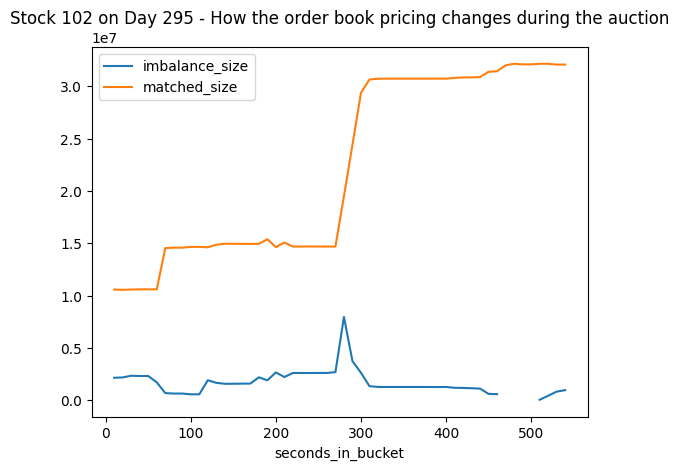

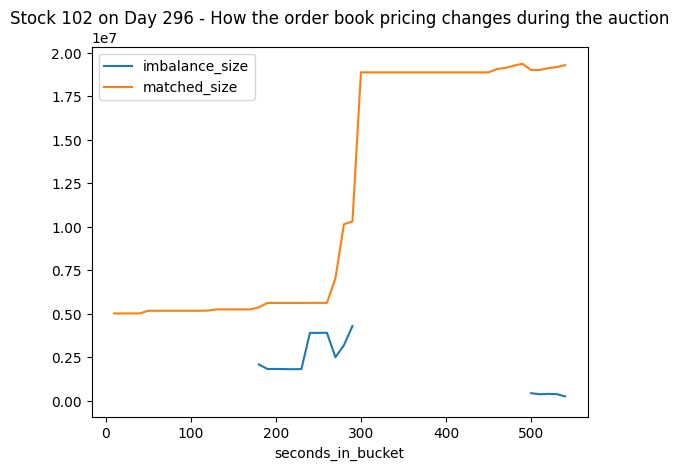

In [32]:
# Check blanced and unbalanced orders
# Observe how the imbalance and matched chnging with each other

for i in range(stocks_first_day, stocks_first_day+2):
    (
        df_102
        .query(f'stock_id =={current_stock_id} & date_id =={i}')
        [['seconds_in_bucket','imbalance_size', 'matched_size']]
        .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f"Stock {current_stock_id} on Day {i} - How the order book pricing changes during the auction")
    )


In [33]:
# Record the fluctuation (The distance from initial_reference_price)

distance = df_102[df_102['seconds_in_bucket'] == 540]['reference_price'].iloc[:] - starting_reference_price
print(distance.iloc[-1])

0.001719000000000137


<class 'numpy.ndarray'>
(186,)


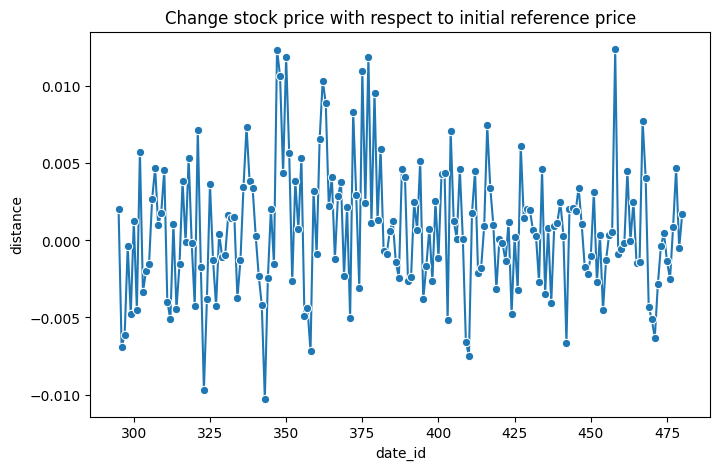

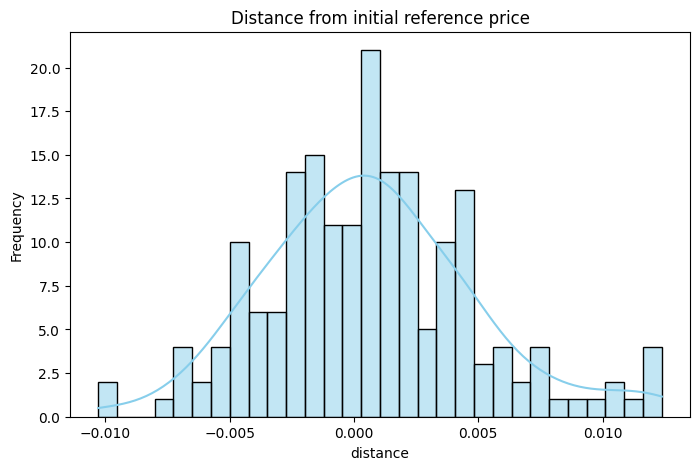

In [34]:
unique_dates = df_102['date_id'].unique()
print(type(unique_dates))
print(unique_dates.shape)
temp_df = pd.DataFrame({'distance': distance.values, 'date_id': unique_dates})

plt.figure(figsize=(8, 5))
sns.lineplot(x='date_id', y='distance', data=temp_df, marker='o')
plt.title('Change stock price with respect to initial reference price')
plt.xlabel('date_id')
plt.ylabel('distance')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=temp_df, x='distance', bins=30, kde=True, color='skyblue')
plt.title('Distance from initial reference price')
plt.xlabel('distance')
plt.ylabel('Frequency')
plt.show()

1. The first day stock_id 102 traded on is 295th day
2. The first reference price of stock_id 102 is 0.9993
3. As we move to the end of the day, the stock_id 102 is getting more balanced.
5. The price difference between initial day price and last day price is 0.001719000000000137. (In almost 200 days the stock price actually increased by an ignorable margin)
6. Checked the correlation between target and other variables, the target is seems like have no correlation with the other variables. Need to investigate further.

### EDA on stock_id 135

- Observe the change of wap with bid and ask price
- Notice how change in volume of stocks and imbalance changing the reference price. 
- Record the fluctuation (change in reference price on each day with repect to it's starting reference price). This is extremely important for the stock which are added , so we can have greater understanding of price movements in the initaial days.

In [35]:
current_stock_id = 135
df_135 = pdf[pdf['stock_id']==135]

print(df_135.shape)
print(df_135.isnull().sum())
print(df_135.describe())

(15950, 17)
stock_id                      0
date_id                       0
seconds_in_bucket             0
imbalance_size                0
imbalance_buy_sell_flag       0
reference_price               0
matched_size                  0
far_price                  8815
near_price                 8700
bid_price                     0
bid_size                      0
ask_price                     0
ask_size                      0
wap                           0
target                        0
time_id                       0
row_id                        0
dtype: int64
       stock_id       date_id  seconds_in_bucket  imbalance_size  \
count   15950.0  15950.000000       15950.000000    1.595000e+04   
mean      135.0    335.500000         270.000000    1.035273e+06   
std         0.0     83.717916         158.750055    2.734118e+06   
min       135.0    191.000000           0.000000    0.000000e+00   
25%       135.0    263.000000         130.000000    0.000000e+00   
50%       135.0    335.

In [36]:
# First day in the stock exhange is ?
print(df_135['date_id'].min())
stocks_first_day = df_135['date_id'].min()


191


In [37]:
# First reference price?
starting_reference_price = df_135[(df_135['date_id']==191) & (df_135['seconds_in_bucket']==0)]['reference_price'].iloc[0]
print(starting_reference_price)

0.998198


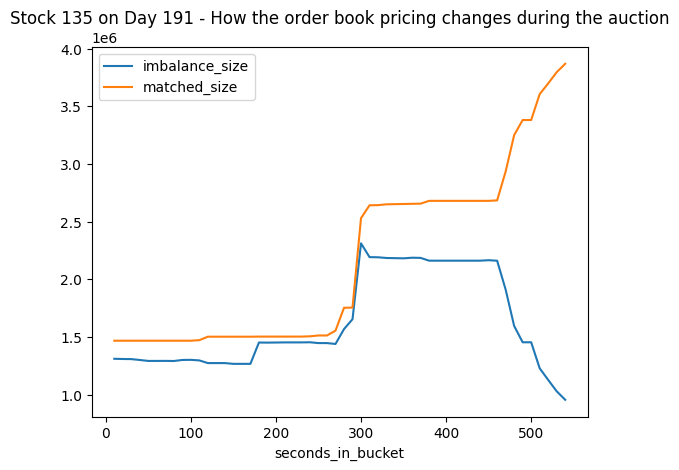

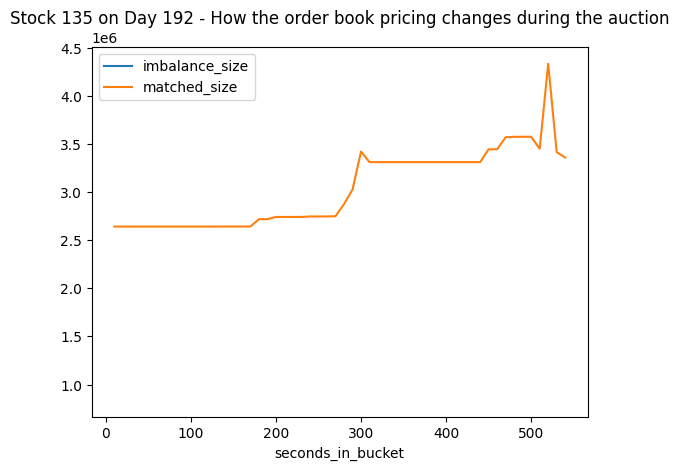

In [38]:
# Check blanced and unbalanced orders
# Observe how the imbalance and matched chnging with each other

for i in range(stocks_first_day, stocks_first_day+2):
    (
        df_135
        .query(f'stock_id =={current_stock_id} & date_id =={i}')
        [['seconds_in_bucket','imbalance_size', 'matched_size']]
        .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f"Stock {current_stock_id} on Day {i} - How the order book pricing changes during the auction")
    )


In [39]:
# Record the fluctuation (The distance from initial_reference_price)

distance = df_135[df_135['seconds_in_bucket'] == 540]['reference_price'].iloc[:] - starting_reference_price
print(distance.iloc[-1])

0.0021769999999999845


<class 'numpy.ndarray'>
(290,)


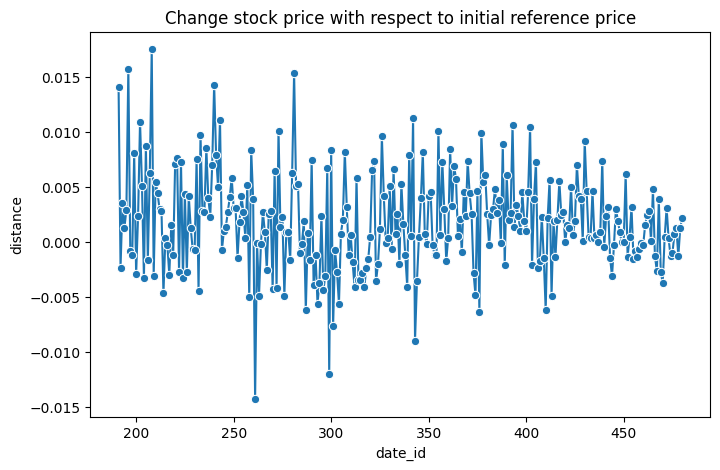

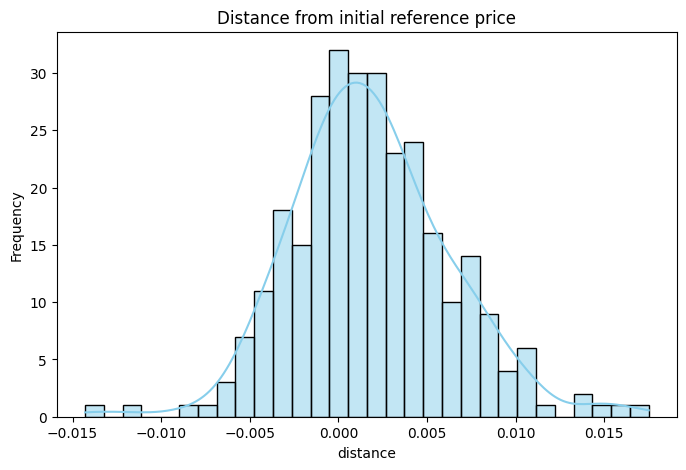

In [40]:
unique_dates = df_135['date_id'].unique()
print(type(unique_dates))
print(unique_dates.shape)
temp_df = pd.DataFrame({'distance': distance.values, 'date_id': unique_dates})

plt.figure(figsize=(8, 5))
sns.lineplot(x='date_id', y='distance', data=temp_df, marker='o')
plt.title('Change stock price with respect to initial reference price')
plt.xlabel('date_id')
plt.ylabel('distance')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=temp_df, x='distance', bins=30, kde=True, color='skyblue')
plt.title('Distance from initial reference price')
plt.xlabel('distance')
plt.ylabel('Frequency')
plt.show()

1. The first day stock_id 135 traded on is 191st day
2. The first reference price of stock_id 135 is 0.9993
3. As we move to the end of the day, the stock_id 135 is getting more balanced.
5. The price difference between initial day price and last day price is 0.0021769999999999845. (In almost 200 days the stock price actually increased by an ignorable margin)
6. Checked the correlation between target and other variables, the target is seems like have no correlation with the other variables. Need to investigate further.

### Helper Functions


- Import Numba for just-in-time (JIT) compilation and parallel processing

**compute_triplet_imbalance()**:
-  Function to compute triplet imbalance in parallel using namba
-  Loop through all combinations of triplets
-  Loop through rows of the DataFrame
-  Find max_val, min_val, mid_val

**calculate_triplet_imbalance_numba()**
-  Function to calculate triplet imbalance for given price data and a DataFrame
-  Convert DataFrame to numpy array for Numba compatibility
-  Calculate the triplet imbalance using the Numba-optimized function
-  Create a DataFrame from the results

**rolling_average()**
-   Calculate the rolling average for a 1D numpy array.
    
-   Parameters: arr (numpy.ndarray): Input array to calculate the rolling average.
-   window (int): The number of elements to consider for the moving average.
    
- Returns: numpy.ndarray: Array containing the rolling average values.

**compute_rolling_averages**

-  Calculate the rolling averages for multiple window sizes in parallel.

-  Parameters:
    -  df_values (numpy.ndarray): 2D array of values to calculate the rolling averages.
    -  window_sizes (List[int]): List of window sizes for the rolling averages.

-  Returns:
    - numpy.ndarray: A 3D array containing the rolling averages for each window size.

In [6]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features


def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    features_array = compute_triplet_imbalance(df_values, comb_indices)

    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

@njit(fastmath=True)
def rolling_average(arr, window):
    n = len(arr)
    result = np.empty(n)
    result[:window] = np.nan  # Padding with NaN for elements where the window is not full
    cumsum = np.cumsum(arr)

    for i in range(window, n):
        result[i] = (cumsum[i] - cumsum[i - window]) / window

    return result

@njit(parallel=True)
def compute_rolling_averages(df_values, window_sizes):
    num_rows, num_features = df_values.shape
    num_windows = len(window_sizes)
    rolling_features = np.empty((num_rows, num_features, num_windows))

    for feature_idx in prange(num_features):
        for window_idx, window in enumerate(window_sizes):
            rolling_features[:, feature_idx, window_idx] = rolling_average(df_values[:, feature_idx], window)

    return rolling_features


## Feature Generation Functions






**Explaination**

**1.`imbalance_features(df)`**:

   -  This function takes a DataFrame df as input.
   -  It calculates various features related to price and size data using Pandas' eval function, creating new columns in the DataFrame for each feature.
   - It then creates pairwise price imbalance features for combinations of price columns.
   - Next, it calculates triplet imbalance features using the Numba-optimized function calculate_triplet_imbalance_numba.
   - It calculates the rolling features.
   - Finally, it calculates additional features, including momentum, spread, intensity, pressure, market urgency, and depth pressure.
   - It also calculates statistical aggregation features (mean, standard deviation, skewness, kurtosis) for both price and size columns.
   - Shifted, return, and diff features are generated for specific columns.
   - Infinite values in the DataFrame are replaced with 0.

**2. `other_features(df)`**:

   - This function adds time-related and stock-related features to the DataFrame.
   - It calculates the day of the week, seconds, and minutes from the "date_id" and "seconds_in_bucket" columns.
   - It maps global features from a predefined dictionary to the DataFrame based on the "stock_id."

**3. `generate_all_features(df)`**:
   - This function combines the features generated by the `imbalance_features` and `other_features` functions.
   - It selects the relevant columns for feature generation, applies the `imbalance_features` function, adds time and stock-related features using the `other_features` function, and then performs garbage collection to free up memory.
   - The function returns a DataFrame containing the generated features, excluding certain columns like "row_id," "target," "time_id," and "date_id."
   



In [7]:
if is_offline:
    df_train = df[df["date_id"] <= split_day]
    df_valid = df[df["date_id"] > split_day]
    
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
else:
    df_train = df
    print("Online mode")

Online mode


In [8]:
if is_train:
    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }

### Using LightGBM models to the extraction of features

In [9]:
import os
import lightgbm as lgb

def imbalance_features_lgbm(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'market_urgency', 'imbalance_momentum', 'size_imbalance']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    return df.replace([np.inf, -np.inf], 0)

def other_features_lgbm(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features_lgbm(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    # Generate imbalance features
    df = imbalance_features_lgbm(df)
    df = other_features_lgbm(df)
    gc.collect()  
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]
    return df[feature_name]


In [18]:
!conda deactivate 

usage: conda [-h] [-v] [--no-plugins] [-V] COMMAND ...
conda: error: argument COMMAND: invalid choice: 'deactivate' (choose from 'clean', 'compare', 'config', 'create', 'info', 'init', 'install', 'list', 'notices', 'package', 'remove', 'uninstall', 'rename', 'run', 'search', 'update', 'upgrade', 'doctor', 'repoquery', 'env')


In [9]:

counter = 0
y_min, y_max = -64, 64
qps = []
cache = pd.DataFrame()

for (test_df, revealed_targets, sample_prediction_df) in iter_test:
    test_df = test_df.drop('currently_scored', axis=1)
    now_time = time.time()
    print('counter:', counter)
    
    cache = pd.concat([cache, test_df], ignore_index=True, axis=0)
    if counter > 0:
        cache = cache.groupby('stock_id').tail(21).reset_index(drop=True)

    feat = generate_all_features_lgbm(cache)[-len(test_df):]
    print(type(feat))
    print(feat.shape)
    print(feat.columns)
    print(feat.head(10))
    break

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
counter: 0
<class 'pandas.core.frame.DataFrame'>
(200, 124)
Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size',
       ...
       'size_imbalance_diff_10', 'dow', 'seconds', 'minute',
       'global_median_size', 'global_std_size', 'global_ptp_size',
       'global_median_price', 'global_std_price', 'global_ptp_price'],
      dtype='object', length=124)
   stock_id  seconds_in_bucket  imbalance_size  imbalance_buy_sell_flag  \
0         0                  0      3753451.43                       -1   
1         1                  0       985977.11                       -1   
2         2                  0       599128.74                        1   
3         3                  0      2872317.54                       -1   
4         

### Summary Feature extraction

- Using the feature extraction functions for each observation we are generating 124 features, earlier we had only 17 features
- Having more features helps us train the model better (since we have 5 million observations, I don't how it's gonna turnout)

In [10]:
import os
import lightgbm as lgb

def load_models_from_folder(model_save_path, num_folds=5):
    loaded_models = []

    # Load each fold model
    for i in range(1, num_folds + 1):
        model_filename = os.path.join(model_save_path, f'doblez_{i}.txt')
        if os.path.exists(model_filename):
            loaded_model = lgb.Booster(model_file=model_filename)
            loaded_models.append(loaded_model)
            print(f"Model for fold {i} loaded from {model_filename}")
        else:
            print(f"Model file {model_filename} not found.")

    # Load the final model
    final_model_filename = os.path.join(model_save_path, 'doblez-conjunto.txt')
    if os.path.exists(final_model_filename):
        final_model = lgb.Booster(model_file=final_model_filename)
        loaded_models.append(final_model)
        print(f"Final model loaded from {final_model_filename}")
    else:
        print(f"Final model file {final_model_filename} not found.")
    
    return loaded_models

# Assuming you have a list of folders from which to load the models
folders = [
    '/kaggle/input/lightgbm-models/modelitos_para_despues',
    '/kaggle/input/ensemble-of-models/results/modelitos_para_despues',
    '/kaggle/input/ensemble-of-models/results (1)/modelitos_para_despues',
    '/kaggle/input/ensemble-of-models/results (2)/modelitos_para_despues',
    '/kaggle/input/ensemble-of-models/results (3)/modelitos_para_despues',
     '/kaggle/input/ensemble-of-models/results (4)/modelitos_para_despues',
     '/kaggle/input/ensemble-of-models/results (5)/modelitos_para_despues',
    '/kaggle/input/ensemble-of-models/results (6)/modelitos_para_despues',
    '/kaggle/input/ensemble-of-models/results (7)/modelitos_para_despues',
]
num_folds = 5
all_loaded_models = []
for folder in folders:
    all_loaded_models.extend(load_models_from_folder(folder))

Model for fold 1 loaded from /kaggle/input/lightgbm-models/modelitos_para_despues/doblez_1.txt
Model for fold 2 loaded from /kaggle/input/lightgbm-models/modelitos_para_despues/doblez_2.txt
Model for fold 3 loaded from /kaggle/input/lightgbm-models/modelitos_para_despues/doblez_3.txt
Model for fold 4 loaded from /kaggle/input/lightgbm-models/modelitos_para_despues/doblez_4.txt
Model for fold 5 loaded from /kaggle/input/lightgbm-models/modelitos_para_despues/doblez_5.txt
Final model loaded from /kaggle/input/lightgbm-models/modelitos_para_despues/doblez-conjunto.txt
Model for fold 1 loaded from /kaggle/input/ensemble-of-models/results/modelitos_para_despues/doblez_1.txt
Model for fold 2 loaded from /kaggle/input/ensemble-of-models/results/modelitos_para_despues/doblez_2.txt
Model for fold 3 loaded from /kaggle/input/ensemble-of-models/results/modelitos_para_despues/doblez_3.txt
Model for fold 4 loaded from /kaggle/input/ensemble-of-models/results/modelitos_para_despues/doblez_4.txt
Mode

In [11]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import time

def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

# Inference
if is_infer:
    import optiver2023
    env = optiver2023.make_env()  # Setting up the environment for the competition
    iter_test = env.iter_test()   # Getting the iterator for the test set
    counter = 0                   # Initializing a counter
    y_min, y_max = -64, 64        # Setting prediction boundaries
    qps = []                      # Queries per second tracking
    cache = pd.DataFrame()        # Initializing a cache to store test data
    
    model_weights = [1/len(all_loaded_models)] * len(all_loaded_models)
    
    for (test_df, revealed_targets, sample_prediction_df) in iter_test:
        test_df = test_df.drop('currently_scored', axis=1)
        now_time = time.time()    # Current time for performance measurement
        print('counter:', counter)
        # Concatenating new test data with the cache, keeping only the last 21 observations per stock_id
        cache = pd.concat([cache, test_df], ignore_index=True, axis=0)
        if counter > 0:
            cache = cache.groupby('stock_id').tail(21).reset_index(drop=True)
        
        feat = generate_all_features_lgbm(cache)[-len(test_df):]
        pred = model_weights[0] * all_loaded_models[0].predict(feat)
        # Generate predictions for each model and calculate the weighted average
        for model, weight in zip(all_loaded_models[1:], model_weights[1:]):
            pred += weight * model.predict(feat)
        
        # Apply your zero-sum and clipping operations
        pred = zero_sum(pred, test_df['bid_size'] + test_df['ask_size'])
        clipped_predictions = np.clip(pred, y_min, y_max)
        
        # Set the predictions in the sample_prediction_df
        sample_prediction_df['target'] = clipped_predictions
        
        # Use the environment to make predictions
        env.predict(sample_prediction_df)
        
        counter += 1
        qps.append(time.time() - now_time)
        
        if counter % 10 == 0:
            print(f"{counter} queries per second: {np.mean(qps)}")

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 2)} hours to reason about")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
counter: 0
counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
10 queries per second: 8.558461499214172
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter: 16
counter: 17
counter: 18
counter: 19
20 queries per second: 8.110746502876282
counter: 20
counter: 21
counter: 22
counter: 23
counter: 24
counter: 25
counter: 26
counter: 27
counter: 28
counter: 29
30 queries per second: 8.004280320803325
counter: 30
counter: 31
counter: 32
counter: 33
counter: 34
counter: 35
counter: 36
counter: 37
counter: 38
counter: 39
40 queries per second: 8.041998893022537
counter: 40
counter: 41
counter: 42
counter: 43
counter: 44
counter: 45
counter: 46
counter: 47
counter: 48
counter: 49
50 queries per second: 8.049135069847107
counter: 50
counter: 51
counter: 52
counter: 53
counter: 54
counter: 55
counter:

In [1]:
env

{'LIBRARY_PATH': ':/opt/conda/lib',
 'PIP_ROOT_USER_ACTION': 'ignore',
 'MKL_THREADING_LAYER': 'GNU',
 'KAGGLE_URL_BASE': 'https://www.kaggle.com',
 'KAGGLE_KERNEL_RUN_TYPE': 'Interactive',
 'MPLBACKEND': 'agg',
 'HOSTNAME': '1209b93181b6',
 'GCSFUSE_METADATA_IMAGE_TYPE': 'DLC',
 'SHLVL': '1',
 'LD_LIBRARY_PATH': '/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib',
 'GIT_COMMIT': '395d3339e8694eaffbc87413e4e019fc596e3888',
 'ENABLE_MULTI_ENV': 'false',
 'HOME': '/root',
 'TENSORFLOW_VERSION': '2.13.0',
 'KMP_SETTINGS': 'false',
 'TESSERACT_PATH': '/usr/bin/tesseract',
 'KAGGLE_DATA_PROXY_URL': 'https://dp.kaggle.net',
 'NODE_OPTIONS': '--max-old-space-size=4096',
 'KMP_BLOCKTIME': '0',
 'TF_CPP_MIN_LOG_LEVEL': '2',
 'BUILD_DATE': '20231111-015858',
 'KAGGLE_GCP_ZONE': 'us-east1-b',
 'KAGGLE_CONTAINER_NAME': 'kaggle_3vR50BTaa8CIByrQwAh9GhJgwPrrPeSZzyHNfM5tWg-154949505-webtier',
 'KAGGLE_GRPC_DATA_PROXY